In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import dill

In [33]:
from tensorflow.python.keras.callbacks import LambdaCallback

#BP模型
def on_epoch_end(epoch, logs):  

    # print(f'Epoch {epoch + 1}, Loss: {logs["loss"]}') 
    print(f'Epoch {epoch + 1}') 
    train_loss = logs.get('loss')  
    val_loss = logs.get('val_loss')  
    train_acc = logs.get('accuracy')  
    val_acc = logs.get('val_accuracy')  
      
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '  
          f'Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')  
    print("\n")

def bp(X_train, y_train,num_epochs):
# Convert labels to one-hot encoding
#     y_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

# Create a sequential model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=1e-6) 
# Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    callback = LambdaCallback(on_epoch_end=on_epoch_end) 
    # Fit the model to the data
    def_history=model.fit(X_train, y_train,validation_split=0.2, epochs=num_epochs, batch_size=16,callbacks=[callback])
    #每10个epoch打印一次loss和accu


    return model, def_history

In [29]:
# 导入数据
X_train = pd.read_csv(r"scale/X_train_minmaxscaler.csv").iloc[:,5:]
X_test = pd.read_csv(r"scale/X_test_minmaxscaler.csv").iloc[:,5:]
y_train = pd.read_csv(r"scale/y_train_minmaxscaler.csv")
y_test = pd.read_csv(r"scale/y_test_minmaxscaler.csv")

In [51]:
print(y_train.value_counts())
print(y_test.value_counts())

label
0        118052
1         36547
Name: count, dtype: int64
label
0        29596
1         9054
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

#不均衡采样
def smote(X_train, y_train):
    # Create an instance of SMOTE
    smote = SMOTE(random_state=10)
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

In [ ]:
#smote采样
X_train, y_train = smote(X_train, y_train)
X_test, y_test = smote(X_test, y_test)

In [38]:
# 模型训练
bp_model,history = bp(X_train, y_train,num_epochs=32)#epoch数修改

Epoch 1/32
7712/7730 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.7594Epoch 1
Epoch 1, Loss: 0.1810, Val Loss: 0.1736, Acc: 0.7595, Val Acc: 0.7660


7730/7730 [==============================] - 21s 3ms/step - loss: 0.1810 - accuracy: 0.7595 - val_loss: 0.1736 - val_accuracy: 0.7660
Epoch 2/32
7727/7730 [============================>.] - ETA: 0s - loss: 0.1732 - accuracy: 0.7630Epoch 2
Epoch 2, Loss: 0.1732, Val Loss: 0.1690, Acc: 0.7630, Val Acc: 0.7660


7730/7730 [==============================] - 24s 3ms/step - loss: 0.1732 - accuracy: 0.7630 - val_loss: 0.1690 - val_accuracy: 0.7660
Epoch 3/32
7715/7730 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.7630Epoch 3
Epoch 3, Loss: 0.1705, Val Loss: 0.1676, Acc: 0.7630, Val Acc: 0.7665


7730/7730 [==============================] - 23s 3ms/step - loss: 0.1705 - accuracy: 0.7630 - val_loss: 0.1676 - val_accuracy: 0.7665
Epoch 4/32
7725/7730 [============================>.] - ETA: 0s - l

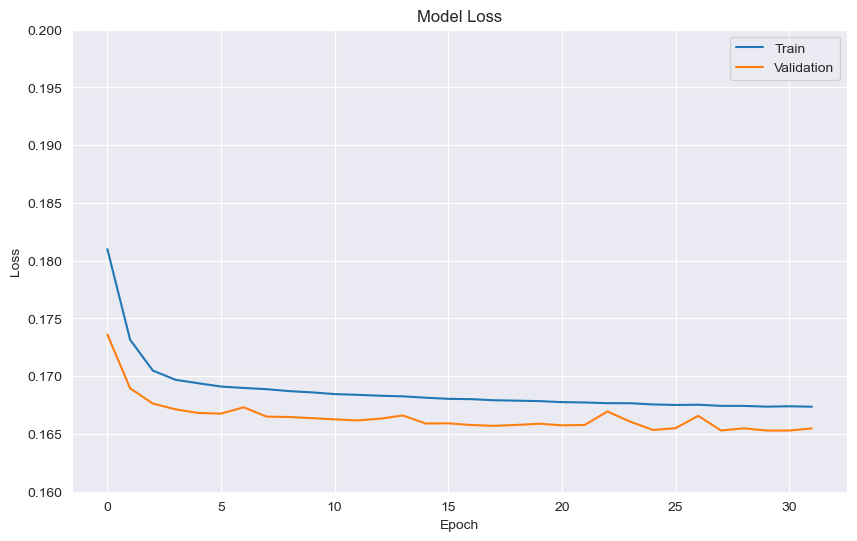

In [52]:
#绘制loss曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0.16, 0.20)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('bp_loss.png')
plt.show()

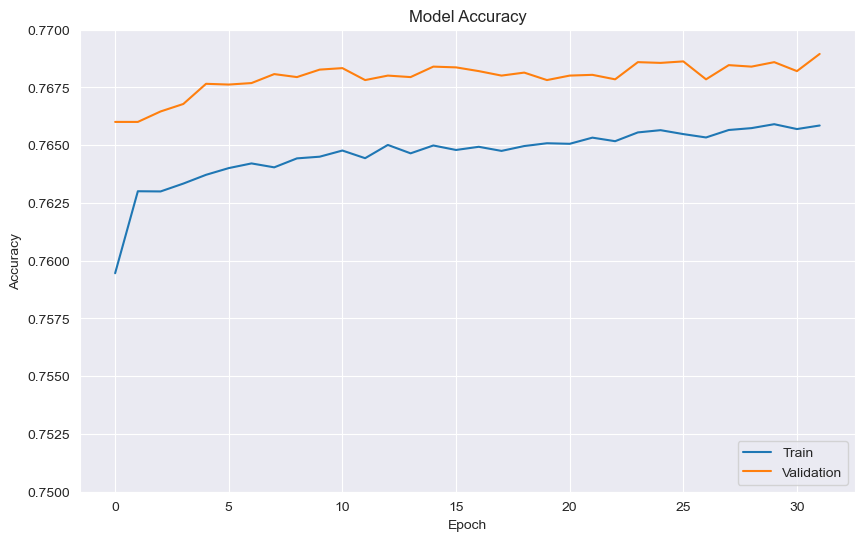

In [53]:
#绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.75, 0.77)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('bp_accuracy.png')
plt.show()

In [27]:
#将每个模型进行保存
# with open('bp_model.pkl', 'wb') as f:
#     dill.dump(bp_model, f)
#使用tensorflow保存模型
bp_model.save('bp_model.h5')

C:\Users\mi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
#bp模型的评价
def evaluate_bp_model(model, X_test, y_test):
    import numpy as np

    # Predict probabilities
    # y_pred_proba = model.predict(X_test)[:, 1]
    y_pred_proba = model.predict(X_test)   #一个神经元输出
    
    # Predict labels
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)    
    # y_pred = np.argmax(model.predict(X_test),axis=1)
    
    # Calculate accuracy, precision, recall, F1-score, and AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    return [accuracy, precision, recall, f1, auc,fpr.tolist(), tpr.tolist()]

In [50]:
import json

# # 加载模型
# def load_model(model_name):
#     with open(model_name, 'rb') as f:
#         model = pickle.load(f)
#     return model
# 加载所有模型
# models = [load_model(f"ML_models/{model_name[i]}_model_{i+1}.pkl") for i in range(len(model_name))]

#计算每个模型的评价指标,bp和svm模型需要单独计算
metrics_name = ['accuracy', 'precision', 'recall', 'f1-score','auc','fpr-score','tpr-score']
#计算每个模型的评价指标值，然后按照模型名，指标名称将结果存入一个字典

metrics = evaluate_bp_model(bp_model, X_test, y_test)
bp_metrics_dict = {metrics_name[j]: metrics[j] for j in range(len(metrics))}
# print(bp_metrics_dict)

1208/1208 [==============================] - 2s 2ms/step
{'accuracy': 0.7676843467011643, 'precision': 0.562396006655574, 'recall': 0.03733156615860393, 'f1-score': 0.07001553599171413, 'auc': 0.6782483176805276, 'fpr-score': [0.0, 3.378834977699689e-05, 3.378834977699689e-05, 6.757669955399378e-05, 6.757669955399378e-05, 0.00010136504933099067, 0.00010136504933099067, 0.00016894174888498447, 0.00016894174888498447, 0.00020273009866198134, 0.00020273009866198134, 0.00023651844843897824, 0.00023651844843897824, 0.00030409514799297204, 0.00030409514799297204, 0.00033788349776996894, 0.00033788349776996894, 0.0004054601973239627, 0.0004054601973239627, 0.0005744019462089471, 0.0005744019462089471, 0.0006081902959859441, 0.0006081902959859441, 0.0006419786457629409, 0.0006419786457629409, 0.0006757669955399379, 0.0006757669955399379, 0.0007095553453169347, 0.0007095553453169347, 0.0007433436950939316, 0.0007433436950939316, 0.0008109203946479254, 0.0008109203946479254, 0.000878497094201919

In [54]:
#以json文件保存字典结果
with open('bp_metrics_dict.json', 'w') as f:
    json.dump(bp_metrics_dict, f)